<a href="https://colab.research.google.com/github/yeonsub/models_from_scratch/blob/main/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# my github: https://github.com/withAnewWorld/models_from_scratch
# my blog
# https://self-deeplearning.blogspot.com/
# https://self-deeplearning.tistory.com/

import torch
import torch.nn as nn
import torch.nn.functional as F

## Ref
1. Transformer <br>
paper(Attention Is All You Need): https://arxiv.org/abs/1706.03762 <br>
cs231n transformer slide: http://cs231n.stanford.edu/slides/2021/lecture_11.pdf<br>
blog: http://peterbloem.nl/blog/transformers <br>
github: https://github.com/bentrevett/pytorch-seq2seq/blob/master/6%20-%20Attention%20is%20All%20You%20Need.ipynb<br>
official PyTorch Transformer code: https://pytorch.org/docs/stable/_modules/torch/nn/modules/transformer.html#Transformer <br>

2. Positional Encoding <br>
blog: https://towardsdatascience.com/master-positional-encoding-part-i-63c05d90a0c3 <br>
blog: https://hongl.tistory.com/231 <br>
blog: https://velog.io/@gibonki77/DLmathPE <br>


## 목차
1. Transformer (roughly) <br>
  - Embedding, Skip Connection, Feed Forward Network
  - Data Flow in Transformer
2. Multi-Head Attention<br>
  - Attention
  - Self Attention
  - Multi-Head Attention
  - Vectorized Multi-Head Attention
3. Masked Multi-Head Attention <br>
4. Transformer (without Positional Encoding) <br>
5. Positional Encoding <br>
  - Count
  - Normalized Count
  - Binary indexing
  - Sinusoidal Positional Encoding
6. Transformer


## Transformer (roughly)

<p align="center">
<img src="https://raw.githubusercontent.com/withAnewWorld/models_from_scratch/main/pic/transformer.PNG" height = 500>
</p>


Transformer는 기존 RNN기반 Seq2Seq와 비슷하게 Encoder(왼쪽 모듈)와 Decoder(오른쪽 모듈)로 이루어져 있지만, <br>
안의 내용은 완전히 탈바꿈한 Deep Learning Model 입니다. <br>

먼저, Embedding과 Add & Norm 그리고 Feed Forward 블럭(block)은 아실법한 내용이니 간단히 설명드리겠습니다. <br>

1. Embedding <br>
Embedding은 lookup table을 이용하여 sequential data를 벡터로 변환하는 기법입니다. <br>
(PyTorch는 nn.Embedding을 통해 해당 기법을 제공하고 있습니다.)<br>

2. Add & Norm <br>
Add의 경우 ResNet에서 개발된 residual connection(or skip connection)을 의미합니다. <br>
Norm의 경우 Batch Normalization 또는 Layer Normalization을 의미합니다. <br> Transformer에서는 Layer Normalization을 사용했습니다. <br>
즉 해당 block은 다음과 같습니다. <br>

#### <center> LayerNorm($x$ + Sublayer($x$)) </center>

3. Feed Forward <br>
해당 block은 Linear Layer와 활성함수(activation func)를 묶어놓은 <br>
다중 퍼셉트론 레이어(Multi Layer Perceptron)입니다. <br>

#### <center> FFN($x$) = $max(0, xW_{1} + b_{1})W_{2} + b_{2}$ </center>

## Data Flow in Transformer
설명을 위해 Transformer를 이용하여 번역(translation) task를 수행하는 경우로 가정하겠습니다.

1. Transformer Encoder

<p align="center">
<img src="https://raw.githubusercontent.com/withAnewWorld/models_from_scratch/main/pic/transformer_encoder.PNG" height = 500>
</p>

RNN이 옆으로 Layer를 쌓았다면 Transformer는 Stack과 같이 위로 Layer를 쌓는 구조입니다(CNN 기반 모델과 비슷하게). <br>

즉 Encoder Block 옆의 (Nx)은 얼마나 Layer를 쌓을 것인지 나타내는 기호입니다. <br>

생소하신 부분은 Multi-Head Attention 모듈 진입 전 데이터가 세 부분으로 나뉘는 구조일 것입니다. <br>
해당 구조는 이전 연산의 결과값이 나눠지는 것(split)이 아니라 각각 온전한 결과값을 받아 특정 연산을 처리한다고 우선 이해하시면 됩니다. <br>

```python
# pseudo code
class TransformerEncoder(nn.Module):
  ...
  def forward(self, x):
    '''
    inputs:
      x(Tensor[batch_size, source_length])
    returns:
      encoder_out(Tensor[batch_size, source_length, embed_dim])
    '''
    # 약어 정의 (src_len: source_length, emb_dim: embed_dim, enc: encoder, mlp:Multi Layer Perceptron)

    embedded = Embedding(x) # (batch_size, src_len) -> (batch_size, src_len, emb_dim)
    encoder_input = positional_encoding(embedded) + embedded # (batch_size, src_len, emb_dim)
    
    # 반복 시작(for N)
    attended = multi_head_attention(encoder_input, encoder_input, encoder_input) #(batch_size, src_len, emb_dim)
    skip_connection = encoder_input + attended
    normalized = LayerNorm(skip_connection)

    mlp_out = feed_forward(normalized)
    # mlp_out.size(): (batch_size, src_len, emb_dim)

    skip_connection = mlp_out + normalized
    normalized = LayerNorm(skip_connection)

    encoder_input = normalized # (batch_size, src_len, emb_dim)
    # 반복 끝(End for)
    
    enc_out = encoder_input
    return enc_out

```

Encoder 안에서 데이터가 어떻게 흐르는지 대충 윤곽이 잡히실 것 같으니 Decoder로 넘어가겠습니다. <br>

2. Transformer Decoder

<p align="center">
<img src="https://raw.githubusercontent.com/withAnewWorld/models_from_scratch/main/pic/transformer_decoder.PNG" height = 500>
</p>

기존의 Seq2Seq 모델과 같이 Transformer Decoder는 Encoder의 결과값을 받아 연산을 수행합니다. <br>

```python
# pseudo code
class TransformerDecoder(nn.Module):
  ...
  def forward(self, y, enc_out):
    '''
    inputs:
      y(Tensor[batch_size, target_length])
      enc_out(Tensor[batch_size, source_length, embed_dim])
    returns:
      output_probabilities(Tensor[batch_size, target_length, output_dim)
    '''
    # 약어 정의 (tgt_len: target_length, emb_dim: embed_dim, dec: decoder, mlp: Multi Layer Perceptron)

    embedded = Embedding(y) # (batch_size, tgt_len) -> (batch_size, tgt_len, emb_dim)
    dec_input = positional_encoding(embedded) + embedded # (batch_size, tgt_len, emb_dim)
    
    # 반복 시작(for N)
    masked_attended = masked_multi_head_attention(dec_input, dec_input, dec_input) #(batch_size, tgt_len, emb_dim)
    skip_connection = dec_input + masked_attended
    normalized = LayerNorm(skip_connection)

    attended = multi_head_attention(enc_out, enc_out, normalized)
    # enc_out: (batch_size, src_len, emb_dim)
    # normalized: (batch_size, tgt_len, emb_dim)
    # attended: (batch_size, tgt_len, emb_dim)

    skip_connection = normalized + attended
    normalized = LayerNorm(skip_connection)

    mlp_out = feed_forward(normalized)
    # mlp_out.size(): (batch_size, tgt_len, emb_dim)

    skip_connection = mlp_out + normalized
    normalized = LayerNorm(skip_connection)

    dec_input = normalized # (batch_size, tgt_len, emb_dim)
    # 반복 끝(End for)
    output_probabilities = Softmax(Linear(dec_input)) # (batch_size, tgt_len, out_dim)
    return output_probabilities

```

cf) Encoder의 N(layer 개수)와 Decoder의 N(layer의 개수)는 서로 같지 않아도 됩니다. (표기상의 편리성때문에 모두 N으로 표시한 것) <br>

이제 (Masked)Multi-Head Attention과 <br>
Positional Encoding만 무엇인지 알면 <br>
Transformer에 대한 이해는 끝나게 됩니다. <br>
우선 알고있는 것을 빠르게 구현한 후 <br>
(Masked)Multi-Head Attention과 Positional Encoding에 대해 설명 드리겠습니다.<br>


In [ ]:
class TransformerEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.embed = nn.Embedding(seq_length, emb_dim)
    self.positional_encoding = PositionalEncoding()

    self.encoder_layer = nn.ModuleList(
        [EncoderBlock() for _ in range(n_layer)]
        )

  def forward(self, x):
    transformer_input = self.positional_encoding(x) + self.embed(x)
    for encoder_block in self.encoder_layer:
      transformer_input = encoder_block(transformer_input)

    out = transformer_input
    return out

class EncoderBlock(nn.Module):
  def __init__(self):
    super().__init__()
    self.multi_head_attn = MultiHeadAttn()
    self.norm1 = nn.LayerNorm()
    self.feed_forward = nn.Sequential(
        nn.Linear(emb_dim, 4*emb_dim),
        nn.ReLU(),
        nn.Linear(4*emb_dim, emb_dim)
    )
    self.norm2 = nn.LayerNorm()

  def forward(self, x):
    attended = self.norm1(self.multi_head_attn(x) + x)
    return self.norm2(self.feed_forward(attended) + attended)

class TransformerDecoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.embed = nn.Embedding(seq_length, emb_dim)
    self.positional_encoding = PositionalEncoding()

    self.decoder_layer = nn.ModuleList(
        [DecoderBlock() for _ in range(n_layer)]
        )

    self.fc_out = nn.Sequential(
        nn.Linear(emb_dim, out_dim),
        nn.SoftMax()
    )

  def forward(self, x, enc_out):
    decoder_input = self.positional_encoding(x) + self.embed(x)
    for decoder_block in self.decoder_layer:
      decoder_input = decoder_block(decoder_input, enc_out, enc_out)

    out = decoder_input
    return self.fc_out(out)

class DecoderBlock(nn.Module):
  def __init__(self):
    super().__init__()
    self.masked_multi_head_attn = MaskedMultiHeadAttn()
    self.norm1 = nn.LayerNorm()

    self.multi_head_attn = MultiHeadAttn()
    self.norm2 = nn.LayerNorm()

    self.feed_forward = nn.Sequential(
        nn.Linear(emb_dim, 4*emb_dim),
        nn.ReLU(),
        nn.Linear(4*emb_dim, emb_dim)
    )
    self.norm3 = nn.LayerNorm()

  def forward(self, x, enc_query, enc_key):
    masked_attended= self.norm1(self.masked_multi_head_attn(x) + x)
    attended = nn.norm2(self.multi_head_attn(enc_query, enc_key, masked_attended) + masked_attended)
    return self.norm3(self.feed_forward(attended) + attended)

class PositionalEncoding(nn.Module):
  pass

class MultiHeadAttn(nn.Module):
  pass

class MaskedMultiHeadAttn(nn.Module):
  pass

## Multi Head Attention

1. Attention

Attention은 한국어로 집중, 관심사항 정도로 번역할 수 있습니다. <br>
Deep Learning에서 Attention은 어느 데이터에 '집중'할 것인가? 정도로 간략히 해석할 수 있습니다. <br>
우선, 예시를 위해 영어 문장을 한국어 문장으로 번역하는 경우에 대해 살펴보겠습니다. <br>

Source Sentence: "Attention Is All You Need" <br>

머리 속으로든 사전을 이용하든 다음과 같은 방식으로 번역이 진행될 것입니다. <br>

<p align="center">
<img src="https://raw.githubusercontent.com/withAnewWorld/models_from_scratch/main/pic/구글_검색.PNG" height = 100, width = 700>
</p>

(google 검색엔진의 결과값으로는 [주목, 주의, 수리, 차려 자세, ...] 가 산출되네요.) <br>

이 때, 중요한 점은 위의 예를 통해 알 수 있듯 Attention과 matching되는 한국어는 꾀나 많다는 점입니다. <br>
이는 단어의 서순, 문장, 문맥, 문화 차이 등 다양한 변수에 의해 같은 단어(source word)도 다른 단어(target word)로 풀이되기 때문입니다. <br>

따라서 해당 문장에서 "Attention"과 매칭되는 여러 한국어 중 <br>
어떤 단어가 가장 적합한지 판단한 후 사용해야 번역이 올바르게 이루어집니다. <br>
(Source 단어와 Target 단어간의 비교)

이러한 내용을 알고리즘으로 구현한 것이 Attention mechanism 입니다. <br>
<br>
**Cosine Similarity** <br>

NLP에서 단어는 Vector로 표현됩니다. <br>
즉 두 단어를 비교하기 위해선 두 Vector를 비교해야합니다. <br>
Vector를 비교하는 가장 손쉬운 방법 중 하나로는 Cosine Similarity(코사인 유사도)가 있습니다.<br>

$$Cosine\ Similarity(\vec A, \vec B) =  \vec A \cdot \vec B/ (|\vec A||\vec B|)$$

(2차원인 경우  $\vec A \cdot \vec B = |\vec A| |\vec B| cos\theta$) <br>
해당 아이디어를 이용하여 Attention mechanism은 벡터의 내적을 이용하여 두 단어간의 유사도를 측정합니다. <br>
cf) 사실 Attention mechanism에는 벡터의 내적말고도 다양한 방법론이 존재합니다. <br>
더 자세히 알아보고 싶으시면 (Luong et al. Effective Approaches to Attention-based Neural Machine Translation. 2015) 을 참고해주세요<br>
2. Self Attention <br>

Self Attention은 위의 예에서 나온 Source 단어와 Target 단어간의 유사도를 측정하는 것이 아닌 <br>
Source 문장 안에서 Source 단어끼리의 유사도를 측정하는 알고리즘입니다. (자기 참조) <br>

cf) Self Attention은 Target sentence에 대해서도 수행할 수 있습니다. <br>
<br>

즉, sentence = ['attention', 'is', 'all', 'you', 'need'] 일 때, <br>

Self Attention은 'attention' 단어와 자신을 포함한 나머지 단어(attention, is, all, you, need)간의 비교입니다. <br>
그러면 Self Attention은 무슨 의미를 가지는 것인지 의문이 드실 것입니다. <br>
<br>
우선 일반적으로 Seq2Seq 모델은 모두 Encoder를 통해 Source Setence의 정보를 맥락 정보(Context Vector)로 압축하여 Decoder에 전달합니다. <br>
즉 번역을 하기 위해서는 Source Sentence의 정보를 효율적으로 압축해야 합니다. <br>
<br>
사람이 번역하는 경우 맥락 정보에는 다음과 같은 사항들이 압축될 것입니다. <br>
1) 각 단어가 가지는 여러 의미 <br>
2) 각 단어의 성분(주어, 목적어, ...) <br>
3) 각 단어가 가지는 긍정적 or 부정적 이미지 <br>
&nbsp;&nbsp;&nbsp; .<br>
&nbsp;&nbsp;&nbsp; .<br>
&nbsp;&nbsp;&nbsp; .<br>
-> 문장의 뜻(맥락) <br>
<br>

기존에는 RNN의 Recurrence 구조를 통해 Context Vector를 만들어냈다면 <br>
Transformer는 Attention만을 이용해서 Context Vector를 만들어낸다는 것이 차이점입니다. <br>

<p align="center">
<img src="https://raw.githubusercontent.com/withAnewWorld/models_from_scratch/main/pic/구글_검색_1.PNG" height = 100 width = 700>
</p>

여기서 주목할 점은 Attention mechanism은 마치 검색엔진을 이용하는 것과 비슷한 구조를 띤다는 점입니다. <br>

즉, 묻고자 하는 바(단어간의 유사도)가 있고 이에 따른 결과값을 산출하는 구조입니다. <br>
이는 프로그래밍적으로 <br>
묻고자 하는 바: **Query** <br>
Query와 비교할 데이터: **Key** <br>
Key값을 통해 접근할 수 있는 데이터: **Value** <br>
로 나타낼 수 있습니다. <br>

원활한 이해를 돕기 위해 다음의 예시를 들겠습니다. <br>

Query = "Attention 한국어 뜻" <br>
Key = ["Attention 한국어로 번역", "Attention", "Attention 노래", "NewJeans", ...] <br>
Value = [각 Key값에 대응(mapping)되는 웹페이지(html)] <br>
Weighted Sum: Value를 통해 가공된 웹페이지(html) <br>

<p align="center">
<img src="https://raw.githubusercontent.com/withAnewWorld/models_from_scratch/main/pic/self_attention.PNG" height = 200 width = 850>
</p>

(Attention의 설명을 위한 예시일 뿐입니다. 정확한 검색엔진 작동방식은 다른 문헌을 참고해주세요) <br>
<br>

Self Attention의 수식은 다음과 같습니다. <br>

$$ y_{i} = \sum_{j} softmax(W_{i,\ j})x_{j} \\ (W_{i,\ j} = x_{i} \cdot x_{j}^{T}) \\(i: 현재\ token,\ j: 모든\ token)$$ <br>
Slef Attention의 수식을 Query, Key, Value를 이용하여 표현하면 다음과 같습니다. <br>

$$ \sum softmax(Q \cdot K^{T})V$$


1) softmax? <br>
내적을 통해 유사도를 구한 후 softmax를 하는 이유는 cosine 유사도와 같이 <br>
정규화(normalized)된 값을 얻기 위함입니다. <br>
왜냐하면 Deep Learning 모델은 크기가 큰 값을 지속적으로 feed할 경우 훈련(train)이 적절하게 되지 않기 때문입니다. <br>
그러면 cosine 유사도 대신 왜 softmax를 사용할까요? <br>
이에 대한 이유로는 deep learning에서 데이터를 해석할 때 <br>
확률로 해석하고자 하는 경향성이 있기 때문으로 생각합니다. <br>

즉, Attention은 Query와 Key의 유사도 확률에 대한 Value의 가중합(Weighted Sum)으로 해석할 수 있습니다. <br>
<br>

2) 가중합? <br>
훈련(train)이 적절하게 이루어질 경우 Embedding vector는 다음과 같은 특성을 띱니다. <br>
vector(king) - vector(man) + vector(woman) $\simeq$ vector(queen) <br>
(ref: Efficient Estimation of Word Representations in
Vector Space) <br>
즉, 임베딩 벡터간 연산이 사람이 이해할 수 있는 방법으로 바뀌게 됩니다. <br>

<br>
한편, 가중합은 다음과 같은 결과를 나타냅니다. <br>

p(attention) + p'(is) + p''(all) + ... <br>

즉, 가중합을 통해 output vector는 표현력이 더욱 풍부해지는 효과를 가집니다. <br>
ex) output = 90%의 (attention) 의미 + 5%의 (is) 의미 + 2%의 (all) 의미 + ...




In [ ]:
# self attention
batch_size, seq_length, emb_dim = 1, 4, 5

x = torch.randn(batch_size, seq_length, emb_dim)
query, key, value = x, x, x

similarity = torch.bmm(query, key.transpose(1, 2)) # (batch_size, seq_length, seq_length)

similarity_p = F.softmax(similarity, dim = -1) # (batch_size, seq_length, seq_length)
weighted_sum = torch.bmm(similarity_p, value) # (batch_size, seq_length, emb_dim)

print('similarity_p')
print(similarity_p)
print('-'*20)
print('weighted_sum')
print(weighted_sum)

similarity_p
tensor([[[9.9637e-01, 1.9821e-04, 3.4106e-03, 2.2651e-05],
         [1.6019e-03, 4.9172e-01, 1.1873e-01, 3.8795e-01],
         [5.8131e-03, 2.5040e-02, 8.6330e-01, 1.0585e-01],
         [4.9540e-08, 1.0499e-04, 1.3582e-04, 9.9976e-01]]])
--------------------
weighted_sum
tensor([[[-0.9495, -1.3336,  0.4078,  1.0864,  1.1539],
         [ 1.3426,  0.2499, -0.8715, -0.5918, -0.8535],
         [ 0.7035, -0.5405, -1.8074,  0.1934, -0.3063],
         [ 2.3354, -0.5784, -0.6451, -1.1405, -2.0048]]])


3. Multi-Head Attention

Multi-Head Attention은 Attention 연산을 한 번에 여러 번 수행하는 것입니다. <br>
즉 한 번의 검색을 통해 원하는 웹페이지를 찾는 대신에 <br>
여러 번의 검색을 통해 원하는 웹페이지를 찾겠다는 생각입니다. <br>

<p align="center">
<img src="https://raw.githubusercontent.com/withAnewWorld/models_from_scratch/main/pic/multi_head_attn.PNG" height = 300>
</p>

$$MultiHead(Q, K, V) = Concat(head_{1},\ head_{2}, ...,\ head_{h})W^{O} \\
(head_{i} = Attention(QW^{Q}_{i}, KW^{K}_{i}, VW^{V}_{i}) \\
(Attention(Q, K, V) = softmax(QK^{T}/\sqrt{d_{k}})V)$$

<br>
$$h: Number\ of\ Multi\ Head(i= 1\ to\ h) \\$$

$$Q: Query,\ W^{Q}_{i}: Linear\ Layer_{i}\ of\ Query \\
K: Key,\ W^{K}_{i}: Linear\ Layer_{i}\ of\ Key \\
V: Value,\ W^{V}_{i}: Linear\ Layer_{i}\ of\ Value \\ $$
$$W^{O} = Linear\ Layer\ of\ Output\ (hd_{v}, d_{model})$$
<br>
1) Linear Layer? <br>
Query, Key, Value에 Linear Layer를 거친 후 Attention을 하는 이유는 <br>
Learnable Parameter(Linear Layer)를 통해 <br>
각각의 embed vector가 $Query,\ Key,\ Value$에 적합한 벡터로 변환되기를 기대하기 때문입니다. <br>

이 때 Linear Layer의 크기는 ($d_{model},\ d_{k}$)입니다. ($d_{k} = d_{v} = d_{model} / h$)<br>

2) $Q \cdot K^{T}/\sqrt{d_{k}}$? <br>
$\sqrt{d_{k}}$로 나누는 이유는 softmax는 값이 커질경우 <br>
gradient exploding / vanishing 문제를 야기하기 때문에 해당 값으로 나눠 이를 해결합니다. <br>


**Visualization of Multi-Head Attention**

<p align="center">
<img src="https://raw.githubusercontent.com/withAnewWorld/models_from_scratch/main/pic/vis_mh_attn.PNG" height = 500>
</p>


In [ ]:
class MultiHeadAttn(nn.Module):
  def __init__(self, emb_dim, n_head, device):
    super().__init__()
    self.W_Q, self.W_K, self.W_V = {}, {}, {}
    self.n_head = n_head
    self.device = device
    for i in range(n_head):
      self.W_Q[i] = nn.Linear(emb_dim, emb_dim // n_head, bias = False)
      self.W_K[i] = nn.Linear(emb_dim, emb_dim // n_head, bias = False)
      self.W_V[i] = nn.Linear(emb_dim, emb_dim // n_head, bias = False)

    self.W_O = nn.Linear(emb_dim, emb_dim, bias = False)
    self.attention = nn.ParameterDict()

  def forward(self, query, key, value, mask = None):
    '''
    inputs
      - query(Tensor[batch_size, query_lenth, emb_dim)
      - key(Tensor[batch_size, key_lenth, emb_dim])
      - value(Tensor[batch_size, value_lenth, emb_dim])
    returns:
    '''
    scale = torch.FloatTensor([emb_dim/self.n_head]).to(self.device) # scale = (d_k/h)
    query, key, value = query.to(self.device), key.to(self.device), value.to(self.device)
    # Q, K, V = (batch_size, seq_length, emb_dim)

    for i in range(self.n_head):
      Q, K, V = self.W_Q[i].to(self.device)(query), self.W_K[i].to(self.device)(key), self.W_V[i].to(self.device)(value)
      # Q, K, V = (batch_size, seq_length, emb_dim // n_head)

      similarity = torch.bmm(Q, K.transpose(1, 2)) / torch.sqrt(scale)
      # similarity: (batch_size, query_length, key_length)

      #masked attention
      if mask is not None:
        mask = mask.to(self.device)
        similarity= similarity.masked_fill_(mask==0, -float('inf'))

      similarity_p = F.softmax(similarity, dim = -1)
      self.attention[str(i)] = torch.bmm(similarity_p, V)
      # (batch_size, query_length, emb_dim // self.n_head)

    multi_head_attn = torch.cat([self.attention[str(i)] for i in range(self.n_head)], dim = -1)
    # (batch_size, query_length, emb_dim)

    return self.W_O.to(self.device)(multi_head_attn)# (batch_size, query_length, emb_dim)

4. Vectorized code

소프트웨어의 속도를 저하시키는 요인에는 여러가지가 있지만 <br>
그 중 코드상에서 많이 나타나는 원인 중 하나는 과도한 반복문의 사용입니다. <br>
위의 코드(Naive algorithm)는 Transformer의 장점인 빠른 속도를 상당히 저하시키기 때문에 실제로 사용되지는 않습니다. <br>

벡터간 연산을 이용하면 반복문을 사용하지 않고 <br>
Naive algorithm과 동일한 결과값을 얻을 수 있습니다. <br>

Naive algorithm은 한 번에 하나씩 일을 처리하는 것과 같지만 <br>
Vectorized code는 여러가지 일을 묶어서 한 번에 일괄적으로 처리하는 것과 같습니다. <br>

<p align="center">
<img src="https://raw.githubusercontent.com/withAnewWorld/models_from_scratch/main/pic/vectorized_code.PNG" height = 300>
</p>

**Vectorized Multi-Head Attention**

<p align="center">
<img src="https://raw.githubusercontent.com/withAnewWorld/models_from_scratch/main/pic/vis_v_mh_attn.png" height = 400>
</p>

In [ ]:
class VectorizedMultiHeadAttn(nn.Module):
  def __init__(self, emb_dim, n_head, device):
    super().__init__()
    self.W_Q = nn.Linear(emb_dim, emb_dim, bias = False)
    self.W_K = nn.Linear(emb_dim, emb_dim, bias = False)
    self.W_V = nn.Linear(emb_dim, emb_dim, bias = False)
    self.W_O = nn.Linear(emb_dim, emb_dim, bias = False)
    self.n_head = n_head
    self.emb_dim = emb_dim
    self.device = device

  def forward(self, query, key, value, mask = None):
    emb_dim = self.emb_dim
    batch_size, query_length, emb_dim = query.size()
    key_length = key.size(1)
    scale = torch.FloatTensor([emb_dim/self.n_head]).to(self.device)
    query, key, value = query.to(self.device), key.to(self.device), value.to(self.device)

    Q, K, V = self.W_Q(query), self.W_K(key), self.W_V(value)
    # Q, K, V: (batch_size, seq_length, emb_dim)

    Q = Q.contiguous().view(batch_size, query_length, self.n_head, emb_dim // self.n_head).transpose(1, 2)
    K = K.contiguous().view(batch_size, key_length, self.n_head, emb_dim // self.n_head).transpose(1, 2)
    V = V.contiguous().view(batch_size, key_length, self.n_head, emb_dim // self.n_head).transpose(1, 2)
    # Q, K, V: (batch_size, self.n_head, seq_length, emb_dim//self.n_head)

    Q = Q.contiguous().view(batch_size * self.n_head, query_length, emb_dim // self.n_head)
    K = K.contiguous().view(batch_size * self.n_head, key_length, emb_dim // self.n_head)
    V = V.contiguous().view(batch_size * self.n_head, key_length, emb_dim // self.n_head)
    # Q. K, V: (batch_size * self.n_head, seq_length, emb_dim//n_head)

    similarity = torch.bmm(Q, K.transpose(1, 2)) / torch.sqrt(scale)
    # (batch_size * self.n_head, query_length, key_length)

    # masked attention
    if mask is not None:
      mask = mask.to(self.device)
      similarity= similarity.masked_fill_(mask==0, -float('inf'))

    similarity_p = F.softmax(similarity, dim = -1)
    # (batch_size * self.n_head, query_length, key_length)

    multi_head_attn = torch.bmm(similarity_p, V)
    # (batch_size * self.n_head, query_length, emb_dim // self.n_head)

    multi_head_attn = multi_head_attn.contiguous().view(batch_size, self.n_head, query_length, emb_dim // self.n_head)
    # (batch_size, n_head, query_length, emb_dim/self.n_head)

    multi_head_attn = multi_head_attn.transpose(1, 2)
    # (batch_size, query_length, self.n_head, emb_dim // self.n_head)

    multi_head_attn = multi_head_attn.contiguous().view(batch_size, query_length, emb_dim)
    # (batch_size, query_length, emb_dim)

    return self.W_O(multi_head_attn) # (batch_size, query_length, emb_dim)

## 결과값 비교(naive, vectorized)

In [ ]:
import time
import numpy as np
def rel_error(x, y):
    """ returns relative error (code from cs231n assignments)"""
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# init parameters
batch_size = 1
seq_length = 3
emb_dim = 24
n_head = 8
x = torch.randn(batch_size, seq_length, emb_dim)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# multi head attn init
multi_head_attn = MultiHeadAttn(emb_dim, n_head, device)
vectorized_multi_head_attn = VectorizedMultiHeadAttn(emb_dim, n_head, device)

# Linear layer 변수 matching
vectorized_multi_head_attn.W_Q.weight = nn.Parameter(torch.cat([multi_head_attn.W_Q[i].weight for i in range(n_head)], dim = 0).to(device))
vectorized_multi_head_attn.W_K.weight = nn.Parameter(torch.cat([multi_head_attn.W_K[i].weight for i in range(n_head)], dim = 0).to(device))
vectorized_multi_head_attn.W_V.weight = nn.Parameter(torch.cat([multi_head_attn.W_V[i].weight for i in range(n_head)], dim = 0).to(device))
vectorized_multi_head_attn.W_O.weight = nn.Parameter(multi_head_attn.W_O.weight.to(device))

with torch.no_grad():
  vectorized_multi_head_attn = vectorized_multi_head_attn.to(device)
  vectorized_multi_head_attn.eval()
  s = time.time()
  vectorized_output = vectorized_multi_head_attn(query= x, key = x, value = x)
  v_elapsed = time.time() - s

  multi_head_attn = multi_head_attn.to(device)
  multi_head_attn.eval()
  s = time.time()
  naive_output = multi_head_attn(query = x, key = x, value = x)
  n_elapsed = time.time() - s

  print('Relative error between vectorized and navie:', rel_error(vectorized_output.cpu().numpy(), naive_output.cpu().numpy()))
  print('vectorized version is %.2fx faster than naive version (device: %s, batch size: %d, seq_length: %d, emb_dim: %d, n_head: %d)'
   % ((n_elapsed / v_elapsed), device, batch_size, seq_length, emb_dim, n_head))

Relative error between vectorized and navie: 0.0
vectorized version is 4.78x faster than naive version (device: cuda, batch size: 1, seq_length: 3, emb_dim: 24, n_head: 8)


## Masked Multi-Head Attention

Data를 모두 병렬처리함으로써 Transformer는 <br>
정답을 모두 알려주고 학습을 진행하는 꼴로 바뀌게 됩니다. <br>

<p align="center">
<img src="https://raw.githubusercontent.com/withAnewWorld/models_from_scratch/main/pic/masked_attn_1.PNG" height = 400>
</p>

**RNN Decoder**

<p align="center">
<img src="https://raw.githubusercontent.com/withAnewWorld/translation_practice/main/pic/decoder.PNG" height = 400>
</p>


우리는 TRansformer를 RNN의 recurrence 구조처럼 Encoder의 <br>

> Context 벡터만을 이용하여 번역을 진행하는 경우 <br>
> Context 벡터와 token[0]를 이용하여 번역을 진행하는 경우 <br>
> context 벡터와 token[0], token[1]을 이용하여 번역을 진행하는 경우 <br>
... <br>

와 같이 이루고 싶습니다. <br>



**Transformer Decoder**

<p align="center">
<img src="https://raw.githubusercontent.com/withAnewWorld/models_from_scratch/main/pic/masked_attn_2.PNG" height = 400>
</p>

그러면 위의 그림과 같이 target sentence를 나누는 방식이 떠오르실 것입니다. <br>
하지만 문제점은 해당 방법은 병렬처리를 할 수 없다는 점에 있습니다. <br>

이를 해결하기 위해 input은 병렬로 feed 하되 Attention 연산을 아래와 같은 구조로 진행하여 유사도 확률을 0으로 만들면<br>
0인 확률은 가중합의 결과에 영향을 끼치지 않으니 autoregressive 특성을 띠게됩니다. <br>


<p align="center">
<img src="https://raw.githubusercontent.com/withAnewWorld/models_from_scratch/main/pic/masked_attn_3.PNG" height = 300>
</p>

In [ ]:
# init query, key
batch_size, emb_dim = 1, 512
query_length, key_length = 5, 5

query = torch.randn(batch_size, query_length, emb_dim)
key = torch.randn(batch_size, key_length, emb_dim)

# similarity
similarity = torch.bmm(query, key.transpose(1, 2)) # (batch_size, query_length, key_length)

# masked attention!
mask = torch.tril(torch.ones(query_length, key_length))
masked_attended = similarity.masked_fill_(mask==0, -float('inf'))[0]
masked_attended

tensor([[-18.6227,     -inf,     -inf,     -inf,     -inf],
        [-35.2376, -11.0780,     -inf,     -inf,     -inf],
        [ -3.2281, -23.5369, -46.5295,     -inf,     -inf],
        [ 10.0105,  -2.7133,  44.1611,   6.4874,     -inf],
        [-31.7343, -22.5114,  15.3287,   6.4891,  11.5723]])

In [ ]:
F.softmax(masked_attended, dim = -1) # similarity_p

tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.2183e-11, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 1.5136e-09, 1.5648e-19, 0.0000e+00, 0.0000e+00],
        [1.4744e-15, 4.3926e-21, 1.0000e+00, 4.3505e-17, 0.0000e+00],
        [3.5540e-21, 3.5989e-17, 9.7703e-01, 1.4155e-04, 2.2832e-02]])

## Transformer(without Positional Encoding)

In [ ]:
class TransformerEncoder(nn.Module):
  def __init__(self, query_length, emb_dim, n_head, n_layer, device):
    super().__init__()
    self.device = device
    self.embed = nn.Embedding(query_length, emb_dim)
    #self.positional_encoding = PositionalEncoding()

    self.encoder_layer = nn.ModuleList(
        [EncoderBlock(emb_dim, n_head, device) for _ in range(n_layer)]
        )

  def forward(self, x):
    #transformer_input = self.positional_encoding(x) + self.embed(x)
    transformer_input = self.embed(x.to(self.device))
    for encoder_block in self.encoder_layer:
      transformer_input =  encoder_block(transformer_input)

    return transformer_input

In [ ]:
class EncoderBlock(nn.Module):
  def __init__(self, emb_dim, n_head, device):
    super().__init__()
    self.n_head = n_head
    self.device = device
    self.multi_head_attn = VectorizedMultiHeadAttn(emb_dim, n_head, device)
    self.norm1 = nn.LayerNorm(emb_dim)
    self.feed_forward = nn.Sequential(
        nn.Linear(emb_dim, 4*emb_dim),
        nn.ReLU(),
        nn.Linear(4*emb_dim, emb_dim)
    )
    self.norm2 = nn.LayerNorm(emb_dim)

  def forward(self, x):
    x = x.to(self.device)
    attended = self.norm1(self.multi_head_attn(query = x, key = x, value = x) + x)
    return self.norm2(self.feed_forward(attended) + attended)

In [ ]:
class TransformerDecoder(nn.Module):
  def __init__(self, query_length, emb_dim, n_head, n_layer, device, out_dim = 512):
    super().__init__()
    self.device = device
    self.n_layer = n_layer
    self.embed = nn.Embedding(query_length, emb_dim)
    #self.positional_encoding = PositionalEncoding()

    self.decoder_layer = nn.ModuleList(
        [DecoderBlock(emb_dim, n_head, device) for _ in range(n_layer)]
        )

    self.fc_out = nn.Sequential(
        nn.Linear(emb_dim, out_dim),
        nn.Softmax(dim = -1)
    )

  def forward(self, x, enc_key, enc_value, tgt_mask):
    #transformer_input = self.positional_encoding(x) + self.embed(x)
    transformer_input = self.embed(x.to(self.device))
    for decoder_block in self.decoder_layer:
      transformer_input = decoder_block(transformer_input, enc_key, enc_value, tgt_mask)
    out = transformer_input
    return self.fc_out(out)

In [ ]:
class DecoderBlock(nn.Module):
  def __init__(self, emb_dim, n_head, device):
    super().__init__()
    self.masked_multi_head_attn =VectorizedMultiHeadAttn(emb_dim, n_head, device)
    self.norm1 = nn.LayerNorm(emb_dim)

    self.multi_head_attn = VectorizedMultiHeadAttn(emb_dim, n_head, device)
    self.norm2 = nn.LayerNorm(emb_dim)

    self.feed_forward = nn.Sequential(
        nn.Linear(emb_dim, 4*emb_dim),
        nn.ReLU(),
        nn.Linear(4*emb_dim, emb_dim)
    )
    self.norm3 = nn.LayerNorm(emb_dim)

  def forward(self, x, enc_key, enc_value, tgt_mask):
    query_length, key_length = x.size(1), enc_key.size(1)
    x, enc_key, enc_value = x.to(device), enc_key.to(device), enc_value.to(device)

    masked_attended= self.norm1(self.masked_multi_head_attn(x, x, x, tgt_mask) + x)
    attended = self.norm2(self.multi_head_attn(masked_attended, enc_key, enc_value) + masked_attended)

    return self.norm3(self.feed_forward(attended) + attended)

In [ ]:
query_length = 10
key_length= 10
batch_size = 1
n_tgt_tokens = 512

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = torch.randint(10, size = (batch_size, query_length))
mask = torch.tril(torch.ones(query_length, key_length))

encoder = TransformerEncoder(query_length = query_length, emb_dim = 512, n_head = 8, n_layer = 6, device = device)
decoder = TransformerDecoder(query_length = query_length, emb_dim = 512, n_head = 8, n_layer = 6, device = device, out_dim = n_tgt_tokens)
with torch.no_grad():
  # naive Transformer Seq2Seq
  encoder.eval()
  encoder.to(device)
  enc_out = encoder(x)

  decoder.eval()
  decoder.to(device)
  dec_out = decoder(x, enc_out, enc_out, mask)

## Positional Encoding(PE)
Transformer의 경우 RNN과 다르게 recurrence 구조가 아니기 때문에 단어간의 위치에 대한 정보가 담기지 않습니다. <br>
Transformer의 구조를 다시 한 번 상기해보면 <br>
> (Masked) Multi-Head Attention <br>
> Feed Forward network<br>
> Layer Normalization + skip connection <br>
> fc_out <br>

로 이루어져 있습니다. <br>
즉, Transformer는 sequential data를 통째로 받아 선형 변환(Linear Mapping)을 하는 구조이기 때문에 <br>
위치에 대한 정보가 학습 중에 담기지 않습니다. <br>
cf) RNN과 Transformer 비교
>RNN: (token[i] -> RNN cell(Linear mapping) -> token[i+1]) <br>
>Transformer: (sequence(tokens) -> Linear mapping -> sequence(tokens)) <br>

추가로 Multi-Head Attention의 위치정보에 대해 생각 해보겠습니다. <br>

$$Attention(i, j): \sum 유사도(token[i],\ token[j])value$$ <br>
sequence_A = [i, am, your, father] <br>
sequence_B = [am, i, your, father] <br>

위의 두 문장을 각각 self attention 연산을 수행한다고 했을 때<br>
i와 your사이의 Attention은 차이가 나지 않습니다. <br>
즉, attention 연산은 순서와 무관한 집합으로서 결과값을 산출하게 됩니다. <br>
하지만 문장의 뜻은 token의 순서에 따라 확연히 다른 의미를 가지게 됩니다. <br>


이에 따라 Transformer가 sequential data를 다루기 위해서는 <br>
추가적으로 위치에 대한 정보를 반영할 수 있는 encoding 방법이 필요합니다.









## Positional Encoding?
그러면 Positional Encoding은 무엇을 뜻하는 것인지 우선 알아보겠습니다. <br>

sequence -> (Positional Encoding Mapping) -> 해당 sequence에서 각 token마다 가지는 고유한 번호(이를 통해 token의 위치정보를 알 수 있다.) <br>

사실 Positional Encoding의 개념은 일상생활 속에서도 많이 사용되고 있습니다. <br>
예를 들어 학교에서 학생들에게 번호를 부여한 후, 번호에 따라 어떤 행위(ex. 번호대로 줄 서세요)<br>
를 부여할 때와 같은 경우가 Positional Encoding의 개념을 일상생활 속에서 적용한 경우입니다. <br>
이를 프로그래밍적인 시야에서 바라보면 <br>
list indexing에 Positional Encoding 개념이 적용되고 있다는 것을 알 수 있습니다. <br>
```python
sequence = ['i', 'am', 'your', 'father']
sequence[0] = 'i'
sequence[1] = 'am'
...

```

## Ideal Criterial for Positional Encoding
1. 각 위치의 Positional Encoding 값은 결정되어야(Deterministic)하는 동시에 유일해야 한다(Uniqueness).
2. 데이터와 관계없이 각 위치의 Positional Encoding 값은 동일해야 한다.
3. 확장성 (데이터의 길이와 관계없이 적용 가능해야 한다.)
4. 간격이 동일하다면 위치와 관계없이 거리는 동일해야 한다.

처음 위의 문장들을 접하시면 감이 잘 안오실 것이기 때문에 하나씩 자세히 설명드리겠습니다. <br>
<br>
1. 1-1) 각 위치의 Positional Encoding 값은 결정되어야 한다(Deterministic) <br>

입력값이 정해지면 매번 같은 결과값을 산출해야합니다. <br>
예를 들어, $y = x^2$에 $x = 2$를 대입하면 언제나 4라는 결과값이 산출됩니다.
<br>

1. 1-2) 각 위치의 Positional Encoding값은 유일해야 한다(Uniqueness)<br>

sequence = [i, am, your, father] 일 때<br>
sequence의 n번째 요소에 접근하기 위한 값은 유일해야 합니다. <br>
즉 sequence[0] = 'i'로 결정되었으면 sequence[k] = 'i'를 만족하는 k가 존재해서는 안됩니다. <br>
언뜻 보면 당연해보이는 이 문구는 python의 list indexing에서 지켜지지 않고 있는 것을 알 수 있습니다. <br>
(물론 이는 편리성 제공을 목적으로 유일성 기준을 일부러 깬 것입니다.)<br>
```python
sequence = ['i', 'am', 'your', 'father']
N = len(sequence) # N = 4
sequence[N - 1] == sequence[-1] # True

```
cf) 유일성이 깨지는 흔한 경우는 주기를 가지는 경우입니다. <br>

<br>

2. 데이터와 관계없이 각 위치의 Positional Encoding 값은 동일해야 한다. <br>

sequence_1=[i, am, your, father] <br>
sequence_2=[tick, tock] <br>

모든 sequential data에 대해 n번째 요소에 접근하기 위한 Positional Encoding값은 동일해야 합니다. <br>
즉, <br>
sequence_1의 0번째 요소 -> sequence_1[0] <br>
sequence_2의 0번째 요소 -> sequence_2[0] <br>
... <br>
모든 sequence의 0번째 요소 -> sequence[0] <br>
<br>
3. 확장성 (데이터의 길이와 관계없이 적용 가능해야 한다.) <br>

길이가 가변적인 데이터에 대해 Positonal Encoding을 할 수 있어야 합니다. <br>
극단적으로 예시를 들면 길이가 무한대인 경우에도 Positional Encoding을 통해 값을 할당할 수 있어야 합니다.
<br>

4. 간격이 동일하다면 위치와 관계없이 거리는 동일해야 한다.

sequence = ['i', 'am', 'your', 'father'] 일 때, <br>
distance('i', 'am') = distance('am', 'your') <br>
이를 일반적인 수식으로 나타내면 다음과 같습니다.<br>
$$distance(x, x+h) = distance(y, y+h)$$
그러면 PE에 어떠한 기법들이 존재하는지 살펴보고 마지막으로 Transformer에 적용된 Sinusoidal Encoding을 이해해보도록 하겠습니다.


## 1. Count <br>
sequence = [i, am, your, father] <br>

해당 문장에 대한 위치정보를 순서대로 자연수를 이용하여 부여하는 방식입니다. <br>
일반적인 python의 list indexing으로 생각할 수 있으며 다른 점은 음수를 통한 indexing은 배제한다는 점입니다. <br>
```python
#pseudo code
sequence[i] = i번째 token (i: 0 or 자연수)
```


<p align="center">
<img src="https://raw.githubusercontent.com/withAnewWorld/models_from_scratch/main/pic/count_encoding.PNG" height = 300>
</p>

Count의 경우 Ideal Criterial를 모두 만족하지만 길이가 매우 긴 sequential data에 대해서는 지나치게 큰 PE의 값이 할당됩니다<br>
문제점
> 지나치게 큰 값을 모델에 지속적으로 feed할 시에 gradient exploding과 같은 문제점을 발생. <br>

즉, 딥러닝 모델은 정규화된 PE 값을 feed할 필요성을 갖습니다. <br>
cf) why? <br>
-> Linear layer = Wx + b <br>
-> Local gradient of W = x <br>
-> 따라서 x의 크기가 클 경우 gradient exploding <br>
for more detail, see(**multiply gate** of Patterns in backward flow): https://cs231n.github.io/optimization-2/#patterns


## 2. Normalized Count
가장 손쉬운 정규화 방법은 sequential data의 각 count를 n_token으로 나누는 방법입니다. <br>

```python
sequence = ['i', 'am', 'your', 'father']
PE = [1/4, 2/4, 3/4, 4/4] # 4: len(sequence)
```

문제점<br>
> 2번 조건을 위배합니다.<br>

2. 데이터와 관계없이 각 위치의 Positional Encoding 값은 동일해야 한다. <br>

```python
sequence_1 = ['i', 'am', 'your', 'father']
PE = [1/4, 2/4, 3/4, 4/4]

sequence_2 = ['tick', 'tock']
PE = [1/2, 2/2]
```

## 3. Binary Indexing

2진수의 경우 0과 1로 이루어져있기 때문에 PE의 값이 지나치게 커질 우려가 없고 벡터로 표현하여 2번 조건을 위배하지 않을 것 같습니다. <br>


<p align="center">
<img src="https://raw.githubusercontent.com/withAnewWorld/models_from_scratch/main/pic/binary_indexing.PNG" height = 200>
</p>

문제점<br>
> 3번 조건을 위배합니다. <br>
> 4번 조건을 위배합니다.<br>

3. 확장성 (데이터의 길이와 관계없이 적용 가능해야 한다.) <br>

<p align="center">
<img src="https://raw.githubusercontent.com/withAnewWorld/models_from_scratch/main/pic/binary_indexing_3.PNG" height = 200>
</p>

위의 경우와 같이 sequential data를 이진수로 나타낼 때 기존 PE 벡터의 차원을 넘어가는 경우 새로 벡터를 형성해서 재할당 해줘야 합니다. <br>

4. 간격이 동일하다면 위치와 관계없이 거리는 동일해야 한다. <br>

```python
#pseudo code
PE(seq[1]) = [0, 1]
PE(seq[2]) = [1, 0]
PE(seq[3]) = [1, 1]

distance([0, 1], [1, 0]) = 2**(1/2)
distance([1, 0], [1, 1]) = 1

```

**solution idea** <br>

3번 문제를 해결하기 위해서 벡터의 차원을 고정시키고 그 안에 실수를 우겨넣으면 해결됩니다. <br>
이에 대한 근거로 실수는 특정 범위(ex 폐구간[0, 1])로 구간을 좁혀도 무한개의 실수를 가지고 있으므로 <br>
1) normalize에 적합하고 <br>
2) 데이터의 길이가 증가하여도 벡터의 차원이 한정된 채로 무한개의 실수가 배정되기 때문에 3번 조건(확장성)을 충족할 수 있습니다. <br>
(Q: 어떻게 0<= x <= 1 일 때 x가 무한개 존재하나요? (x는 실수) A: ~~가까운 수학과에 물어보세요~~ 실수의 조밀성을 검색해주세요.) <br>

cf) 해당 아이디어는 lookup table을 이용한 embedding 기법의 아이디어와도 유사한 부분이 있으므로 PE로 embedding을 사용할 수 있습니다. <br>
(다만 이상적 PE 기준에 부합하게 학습이 될 것인지는 실험을 통해 확인을 해봐야겠지만 ~~뭐가 됐든 결과만 좋으면 끝~~) <br>
-> embedding을 통한 PE에 더 자세히 알고 싶으시다면 Positional Embedding을 검색해주세요. <br>

4번 문제의 경우를 해결하기 위해 위치에 따라 일정한 값으로 변환해주는 실수함수가 필요합니다. <br>
$$즉, |f(pos + pos') - f(pos)| = distance(pos,\ pos') $$

## Sinusoidal Positional Encoding
solution idea를 통해 도출된 함수는 삼각함수(sin, cos)입니다. <br>
(왜 갑자기 삼각함수냐고 물으신다면 저도 모릅니다. ~~수학과에 물어보세요 제발~~ ref: towardsdatascience blog 참고)

<p align="center">
<img src="https://raw.githubusercontent.com/withAnewWorld/models_from_scratch/main/pic/sinusoidal_positional_encoding.PNG" height = 200>
</p>

$$pos(i, j) = sin(i/n^{2j/d}) $$
$$(i: token's\ position\ in\ sequence,\ j: each\ dimension,\ n: some\ real\ number, \ d: dimension) $$<br>
sin함수를 통해 PE 값은 [-1, 1] 사이의 값을 갖게 됩니다. <br>
위의 수식을 천천히 살펴봅시다. <br>
sequence = ['i', 'am', 'your', 'father'] <br>
PE(sequence[1]) -> 크기가 d인 행벡터, 벡터의 모든 값은 -1과 1사이의 실수 중 하나를 배정받는다.<br>
i = 1인경우, 즉 sequence[1] = 'am'에 대해 다음과 같이 position encoding 됩니다.

<p align="center">
<img src="https://raw.githubusercontent.com/withAnewWorld/models_from_scratch/main/pic/sinusoidal_positional_encoding_1.PNG" height = 60>
</p>

<br>
> 그래프를 통한 이해(일반적 버전)

<p align="center">
<img src="https://raw.githubusercontent.com/withAnewWorld/models_from_scratch/main/pic/sinusoidal_positional_encoding_2.PNG" height = 350>
</p>


그러면 Sinusoidal PE가 이상적 기준을 모두 만족하는지 살펴보겠습니다. <br>
1. 각 위치의 Positional Encoding 값은 결정되어야(Deterministic)하는 동시에 유일해야 한다(Uniqueness).

-> 일반적으로 삼각함수는 주기(cycle)를 가지기 때문에 위의 조건을 만족하지 않습니다. <br>
그러면 주기를 가지지 않는 함수로 값을 배정을 해야하는데 주기를 가지는 함수를 어떻게 주기를 가지지 않는 함수로 바꿀 수 있을까요? <br>

A: 주기를 무한대로 만들면 됩니다. <br>

먼저, sin함수의 경우 $(0,\ {\pi}/2)$ 에서 증가함수라는 것을 짚고 넘어가겠습니다. <br>

**Suppose)** <br>
PE들 중 마지막 열을 제외한 모든 값들이 동일한 경우가 있다고 가정을 하겠습니다. <br>
즉, 마지막 열의 값만 서로 같다면 두 벡터는 동일하기 때문에 1번 조건에 위배됩니다. <br>

<p align="center">
<img src="https://raw.githubusercontent.com/withAnewWorld/models_from_scratch/main/pic/sinusoidal_positional_encoding_3.PNG" height = 350>
</p>

n이 적당히 큰 수가 아닌 $\lim_{n \to \infty} n$ 인 경우, <br>
pos < pos' -> PE(pos) < PE(pos') 를 만족합니다. $(\because \ 증가함수)$ <br>
즉 마지막 열의 값은 n이 충분히 클 경우 절대 동일한 값이 나오는 case가 존재하지 않습니다. <br>
따라서 1번 조건을 만족합니다.

2. 데이터와 관계없이 각 위치의 Positional Encoding 값은 동일해야 한다. <br>

차원을 고정시키고 각 위치의 Positional Encoding의 값을 정적인 함수를 통해 실수값을 배정하므로 2번 조건을 만족합니다. <br>

3. 확장성 (데이터의 길이와 관계없이 적용 가능해야 한다.)

2번 조건과 마찬가지의 이유로 3번 조건을 만족합니다. <br>

4. 간격이 동일하다면 위치와 관계없이 거리는 동일해야 한다.

잠깐 곁길로 새서, 사실 여러분에게 아직 말하지 않은 사실이 있습니다. <br>
논문에서 제시한 PE의 수식은 정확히 다음과 같습니다. <br>
$$PE(i, 2j) = sin(i/n^{2j/d}) \ \ (짝수인 경우)$$
$$PE(i, 2j+1) = cos(i/n^{2j/d}) \ \ (홀수인 경우)$$
안그래도 골치아픈 수식이였는데 더 골치아파졌습니다. <br>

$$PE = [sin(i/n^{0/d}),\ cos(i/n^{0/d}),\ sin(i/n^{2/d}),\ cos(i/n^{2/d}),\ ... ,\ sin(i/n^{2}),\ cos(i/n^{2})]$$

sin함수를 쓸거면 sin함수만 쓰고 cos함수를 쓸거면 cos함수만 쓰지 도대체 왜 이럴까요? <br>
-> Transformer는 선형 변환으로 이루어져 있기 때문에 <br>
선형 변환을 통해 각 position data에 접근할 수 있는 것이 자연스럽고 좋은 결과를 도출할 것으로 기대됩니다. <br>
$$ PE[pos] = Linear(PE[pos']) $$

그러면 어떤 선형 변환을 통해 서로 전환이 될 수 있을까요? <br>
<br>
삼각함수는 결국 좌표공간과 벡터간의 이루는 각도를 통해 특정 좌표를 나타내는 방법입니다. <br>
즉 삼각함수의 변수는 '각도' 입니다. <br>
해당 아이디어를 통해 PE 벡터는 회전을 통해 다른 PE 벡터로 변환될 수 있다는 점이 떠오를 수 있습니다. <br>
<br>
**회전 변환**

<p align="center">
<img src="https://raw.githubusercontent.com/withAnewWorld/models_from_scratch/main/pic/rotation_transform.PNG" height = 130>
</p>

간단한 예시를 위해 dimension = 1인 경우의 PE를 살펴보겠습니다.
$$PE(\theta) = [sin(\theta/n^{0/1}),\ cos(\theta/n^{0/1})] = [sin(\theta),\ cos(\theta)]$$
$$PE(\theta + \phi) = [sin(\theta + \phi/n^{0/1}),\ cos(\theta + \phi/n^{0/1})] = [sin(\theta + \phi),\ cos(\theta + \phi)]$$

위의 선형변환을 약간 변형하면 두 position간 변환이 이루어집니다. <br>
그러면 n차원의 경우 어떻게 될까요? <br>


<p align="center">
<img src="https://raw.githubusercontent.com/withAnewWorld/models_from_scratch/main/pic/rotation_transform_1.PNG" height = 130>
</p>

이제 다시 원래의 명제로 돌아와서 <br>
(4. 간격이 동일하다면 위치와 관계없이 거리는 동일한지) <br>
에 대해 증명하겠습니다. <br>

먼저, 인접한 Position간 각각의 dim(j)의 각도차이는 모두 동일한 것을 짚고 넘어가겠습니다. <br>

<p align="center">
<img src="https://raw.githubusercontent.com/withAnewWorld/models_from_scratch/main/pic/rotation_transform_2.PNG" height = 300>
</p>

여기서 $l$과 $l'$은 cos 제 2 공식에 의해 같습니다. <br>
따라서 회전각도가 같으면 벡터간 거리는 같습니다. (n차원 증명은 여러분에게 맡기겠습니다. 화이팅)<br>
그리고 sequential 데이터의 간격과 각도 차이는 위치와 관계없이 비례합니다. <br>
따라서 4번 조건을 만족합니다.<br>


cf) 논문에서는 PE벡터의 분모(n)로 10,000을 선택하였습니다. <br>
왜 10,000인지에 대한 설명은 나오지 않지만 <br>
1) floating error를 일으키지 않으면서 <br>
2) 현재까지 다뤄지는 sequential data를 모두 다루기에 <br>
충분히 큰 수라 선택하지 않았나 싶습니다. (실험적으로)

$$PE(pos, 2i) = sin(pos/10,000^{2i/d})$$
$$PE(pos, 2i+1) = cos(pos/10,000^{2i/d})$$

In [ ]:
# this code is from cs231n/assignments3/CS231n/transformer_layer.py (copy & paste)

class PositionalEncoding(nn.Module):
    """
    Encodes information about the positions of the tokens in the sequence. In
    this case, the layer has no learnable parameters, since it is a simple
    function of sines and cosines.
    """
    def __init__(self, embed_dim, dropout=0.1, max_len=5000):
        """
        Construct the PositionalEncoding layer.
        Inputs:
         - embed_dim: the size of the embed dimension
         - dropout: the dropout value
         - max_len: the maximum possible length of the incoming sequence
        """
        super().__init__()
        #self.dropout = nn.Dropout(p=dropout)
        assert embed_dim % 2 == 0
        # Create an array with a "batch dimension" of 1 (which will broadcast
        # across all examples in the batch).
        pe = torch.zeros(1, max_len, embed_dim)

        i=torch.arange(0, max_len).reshape(max_len, -1)
        j= 10000**-(torch.arange(0, 1, 2/embed_dim))
        pe[0, :, torch.arange(0, embed_dim, 2)]= torch.sin(i*j)
        pe[0, :, torch.arange(1, embed_dim, 2)]= torch.cos(i*j)

        # Make sure the positional encodings will be saved with the model
        # parameters (mostly for completeness).
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Element-wise add positional embeddings to the input sequence.
        Inputs:
         - x: the sequence fed to the positional encoder model, of shape
              (N, S, D), where N is the batch size, S is the sequence length and
              D is embed dim
        Returns:
         - output: the input sequence + positional encodings, of shape (N, S, D)
        """
        N, S, D = x.shape

        output= x+self.pe[:, :S, :]
        # output = self.dropout(output)

        return output

## Heatmap of Positional Encoding

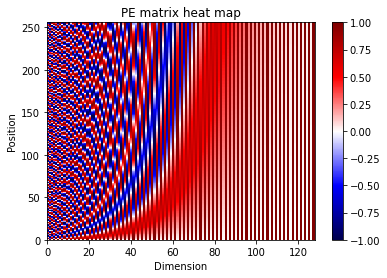

In [ ]:
# this code is from https://towardsdatascience.com/master-positional-encoding-part-i-63c05d90a0c3 (copy & paste)

import matplotlib.pyplot as plt
dim = 128
max_len = 256
pe = PositionalEncoding(dim, max_len = max_len)
x = torch.randn(1, max_len, dim)
pe_matrix = pe(x) - x # this code is different from the original

# heatmap plot
plt.pcolormesh(pe_matrix[0], cmap='seismic') # I use different cmap for fun and to make difference vivid
plt.xlabel('Dimension') # I think dimension is better than depth(from original) for unity
plt.xlim((0, dim))
plt.ylabel('Position')
plt.title("PE matrix heat map")
plt.colorbar()
plt.show()

## Analysis of heatmap
1) Dimension이 증가할수록 각 position간의 차이(세로선)는 미미합니다.(비슷한 색을 띰) <br>
2) Dimension을 조금 더 줄여도 Deterministic & Uniqueness 조건을 만족할 것 같습니다.

## Transformer

In [ ]:
class TransformerEncoder(nn.Module):
  def __init__(self, query_length, emb_dim, n_head, n_layer, device):
    super().__init__()
    self.device = device
    self.embed = nn.Embedding(query_length, emb_dim)
    self.pe = PositionalEncoding(emb_dim)

    self.encoder_layer = nn.ModuleList(
        [EncoderBlock(emb_dim, n_head, device) for _ in range(n_layer)]
        )

  def forward(self, x):
    transformer_input = self.pe(self.embed(x.to(self.device)))
    for encoder_block in self.encoder_layer:
      transformer_input =  encoder_block(transformer_input)

    return transformer_input


class TransformerDecoder(nn.Module):
  def __init__(self, query_length, emb_dim, n_head, n_layer, device, out_dim = 512):
    super().__init__()
    self.device = device
    self.n_layer = n_layer
    self.embed = nn.Embedding(query_length, emb_dim)
    self.pe = PositionalEncoding(emb_dim)

    self.transformer_layer = nn.ModuleList(
        [DecoderBlock(emb_dim, n_head, device) for _ in range(n_layer)]
        )

    self.fc_out = nn.Sequential(
        nn.Linear(emb_dim, out_dim),
        nn.Softmax(dim = -1)
    )

  def forward(self, x, enc_key, enc_value, tgt_mask):
    transformer_input = self.pe(self.embed(x.to(self.device)))
    for transformer_block in self.transformer_layer:
      transformer_input = transformer_block(transformer_input, enc_key, enc_value, tgt_mask)
    out = transformer_input
    return self.fc_out(out)

In [ ]:
query_length = 10
key_length= 10
batch_size = 1
n_tgt_tokens = 512
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = torch.randint(10, size = (batch_size, query_length))
mask = torch.tril(torch.ones(query_length, key_length))

encoder = TransformerEncoder(query_length = query_length, emb_dim = 512, n_head = 8, n_layer = 6, device = device)
decoder = TransformerDecoder(query_length = query_length, emb_dim = 512, n_head = 8, n_layer = 6, device = device, out_dim = n_tgt_tokens)
with torch.no_grad():
  # naive Transformer Seq2Seq
  encoder.eval()
  encoder.to(device)
  enc_out = encoder(x)

  decoder.eval()
  decoder.to(device)
  dec_out = decoder(x, enc_out, enc_out, mask)

In [ ]:
dec_out.size()

torch.Size([1, 10, 512])

## Transformer의 장점
그래서 RNN으로 줄곧 잘 해왔는데 Transformer를 개발한 이유가 뭘까요? <br>
많은 이유가 있지만 크게 다음의 두가지로 압축할 수 있을 것 같습니다. <br>

1. 성능
2. 속도

1) 성능

>Transformer 이전 번역 문제에서 SOTA 모델은 Attention 기반 RNN Seq2Seq 였습니다. <br>
>RNN 모델은 Multi-Head Attention이 아닌 단일 Attention을 수행하여 성능이 Transfomer 만큼 뛰어나지 않습니다. <br>
>즉 Multi-Head Attention 모듈이 Transformer 성능의 핵심입니다. <br>

<br>

2) 속도
> Recurrence구조를 가지는 RNN과 다르게 Transformer는 병렬처리를 통해 데이터를 모두 처리합니다. <br>
> 병렬처리의 위력은 Vectorized code에서 잘 보셨을 것입니다. <br>


<br>

의의
> 일반적으로 모델의 성능과 속도는 trade-off 관계에 있습니다. <br>
> 하지만 Transformer는 이러한 반비례 관계를 깨버린 동시에 <br>
> 통역사와 비슷한 수준의 번역 성능을 보여 NLP 영역에 판도를 뒤바꾸었습니다. <br>
> 이제 Transformer 모델은 NLP에 국한되는 것이 아닌 Deep Learning 전반에 깊게 뿌리 뻗었습니다. <br>
> 심지어 RNN뿐 아니라 CNN 또한 Transformer로 대체하는 분위기가 형성되었고 결과 또한 CNN을 능가하고 있습니다. <br>
> ex) ViT, DETR, DINO(Transformer + self supervised learning), ... <br>
> 해당 notebook을 통해 Transformer의 모든 것을 이해하셨길 바랍니다 :)


## Try!
1. code Refactoring <br>
최대한 깔끔한 코드로 나타내려했지만 역량 한계 & 설명의 필요성 때문에 코드가 지저분합니다. <br>
조금 더 유지보수하기 쉽고 깔끔한, 그리고 error에 대응하는 코드로 Refactoring 해보세요! <br>
Plus) 조금 더 속도가 빠르고(more vectorized) 메모리 사용이 적은 모델로 Refactoring 해보세요! <br>

2. Make your own Transformer <br>
이해한 내용을 바탕으로 논문과 reference, ref code 등을 이용하여 여러분이 직접 Transformer를 구현해보세요!

3. NLP task using Transformer <br>
Transformer를 이용하여 NLP task(번역, 텍스트 분류 등)를 수행해보세요! <br>
cf) Transformer를 통해 Vision task(image classification, object dection, ...)에도 도전해보세요!<br>

4. Design model based on Transformer <br>
현재 다양한 NLP영역에서 SOTA성능을 보이는 GPT, BERT와 같은 Transformer 기반 model을 설계해보세요!

5. **설계 / 설명 오류, 생략된 이론 등을 말해주세요!** <br>
같이 성장해요 :)

6. anything with your creativity! <br>